# Overlap Tomography Code

This code performs the tomographic reconstruction from the overlap tomography experiment. Specifically, this code is for the overlap tomography of a single-photon Fock state. The basis for this reconstruction is a convex-optimization semidefinite programming (SDP) algorithm used to solve the matrix equation $M=CP$, where $M$ is a column vector containing all of the overlap measurements, $C$ is a coefficient matrix that can be calculated from the coherent state calibration measurements, and $P$ is the unknown density operator in Liouville vector representation. Instead of directly inverting $C$, which could cause problems due to even small errors in the calibration blowing up upon matrix inversion, the more robust minimization of the $L2$ norm, $||M-CP||_2$ can be performed. Minimizing this quantity yields a global minimum that this computationally efficient to solve. Additionally, we can use physicality constraints on the density matrix $\rho=\rho^\dagger$ and $\text{Tr}[\rho]=1$ to ensure a physical reconstruction. This code uses the Python libraries CVXPY and CVXOPT to perform the optimization.

Once the reconstruction is performed, a second optimization problem can be solved to compensate for calibrated loss, as the loss process is just a different matrix mapping from the pure state to the loss-degraded state.

In [1]:
import time
from matplotlib import rc
import math
from qutip import *
#from qutip.ipynbtools import plot_animation
#import qutip

import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex

import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial
from scipy.special import binom
from scipy import linalg
import scipy as scp
import cvxpy as cp
import cvxopt

global N_dim
global N_trun 
N_dim = 10;
N_trun = 6;

First we'll calculate the coefficient matrix from the measured coherent states. We could use directly measured results, but we can improved our results by including some additional calibrations such as imperfect visibility between the signal photon and the coherent state. If we assume that the fiber collects everything, then the only mode we should care about is the portion of the signal that correctly interferes with the coherent state, but in actuality, we also measure the non-interferring photons. Additionally, when calibrating the coherent state, we collect more light than actually interferes with the signal, as some of this coherent state will not overlap. Thus, when calculating the coefficient matrix, the value of the coherent state used should actually be smaller than what is measured by a factor of the visibility. Below, we have the measured amplitudes of the five non-zero coherent state values which were calibrated before and after each experimental run. The values used for the reconstruction is the average of the measurements scaled by the visibility.

In [2]:
'''Coherent State calibrations'''
vis=0.9
M=vis**2
alpha_LO1 = np.sqrt(2)*np.array([0,0.2392,0.2577, 0.2877, 0.3158, 0.50774]) #Measured values at start
alpha_LO2 =np.sqrt(2)*np.array([0,0.2653,0.2728, 0.293 ,0.3198, 0.5054])    #Measured values at end
alpha_LO=(alpha_LO1+alpha_LO2)/2
alpha_LO_new=alpha_LO*vis

In [3]:
np.sqrt(1-M)

0.4358898943540673

The measured amplitudes are only part of the calibrations. Additionally, we need the phase of each measurement. In this experiment, I used a mirror-mounted PZT to vary the phase of the overlapping coherent states. Each shift to the piezo applied a 0.58 radian phase. Additionally, because the EOM was used to control the amplitudes of the coherent states, the phase also depends on the amplitude since changing the voltage on the EOM will change the phase. The phases were all calibrated with classical beams before the experimental data collection. At the end of the cell below, the variable 'Final_prob' is now a 2D array that contains all of the coefficients needed to solve the SDP problem. 

In [4]:
'''Create a matrix of the coefficients of all of the 
coherent states used to probe the state to tomograph'''
prob_matrix_tomo=[]
phase_step=0.58 #the PZT changes the phase by 0.58 rads
EOM_phase_step=0.277 #phase change due to EOM in rads

'''In this set of data, I did i=24;16;8;1 for the EOM values, so I need to assign EOM values to negative phases.
Hence the minus sign on the EOM_phase_step in line 22 of this cell'''
amp_num=5 #number of coherent state probe amplitudes (not including vacuum)

for i in range(amp_num):
    amp=alpha_LO_new[i+1];
    if (i+1)>4:
        EOM_phase=np.e**(-EOM_phase_step*(i-5)*1j)
    elif 5>(i+1)>0:
        EOM_phase=np.e**(-EOM_phase_step*(i)*1j)
    else:
        EOM_phase=1
    for k in range(10): #(number of phases used)
        phase=np.e**(k*1j*phase_step)
        B = coherent_dm(N_dim,amp*phase*EOM_phase).full()
        ele = B.flatten()
        prob_matrix_tomo.append(ele)

'''Add the vacuum component last'''
B_vac=coherent_dm(N_dim,0).full()
prob_matrix_tomo.append(B_vac.flatten())

Final_prob = np.array(prob_matrix_tomo);


The cell below contains the measured photon-number probability distributions from the TES for each overlap setting for five values of coherent state amplitude each at 10 phases from 0 to $2\pi$. The first set of 'amp_0' is when the coherent state field is block, thus the signal is simply overlapped with vacuum.

In [5]:
'''experimental number distributions go here'''
refl_tot=.4 #This is the loss we determined from the heralding ratio

amp_0_1=[0.8134,0.1791,0.0075,0,0,0,0]
amp_0_2=[0.7974,0.2026,0,0,0,0,0]
amp_0_3=[0.7869,0.2131,0,0,0,0,0]
amp_0=np.zeros(7)
for i in range(len(amp_0_1)): #average the 3 measurements
    amp_0[i]=(amp_0_1[i]+amp_0_2[i]+amp_0_3[i])/3
    
amp_1_p1 = [0.6619, 0.3094,0.0288,0,0,0,0]
amp_1_p2 = [ 0.6917,0.2667,0.0417,0,0,0,0]
amp_1_p3 = [ 0.6771,0.2396,0.0833,0,0,0,0]
amp_1_p4 = [ 0.6579,0.2895,0.0439,0.0088,0,0,0]
amp_1_p5 = [0.66950,0.3136,0.0169,0,0,0,0]
amp_1_p6 = [0.7254,0.2042,0.0634,0.007,0,0,0]
amp_1_p7 = [0.7109,0.25,0.0391,0,0,0,0]
amp_1_p8 = [0.7284,0.2407,0.0309,0,0,0,0]
amp_1_p9 = [0.6855,0.2642,0.044,0.0063,0,0,0]
amp_1_p10 = [ 0.7414,0.2241,0.0345,0,0,0,0]

amp_2_p1 = [0.7143,0.2476,0.0381,0,0,0,0]
amp_2_p2 = [ 0.7596,0.2212,0.0192,0,0,0,0]
amp_2_p3 = [ 0.7042,0.2535,0.0352,0.007,0,0,0]
amp_2_p4 = [ 0.731,0.2164,0.0526,0,0,0,0]
amp_2_p5 = [0.7345,0.2373,0.0226,0.0056,0,0,0]
amp_2_p6 = [0.6842,0.25,0.0658,0,0,0,0]
amp_2_p7 = [0.6698,0.283,0.0472,0,0,0,0]
amp_2_p8 = [0.7068,0.2408,0.0419,0.0105,0,0,0]
amp_2_p9 = [0.7341,0.2197,0.0405,0.0058,0,0,0]
amp_2_p10=[0.6587,0.3077,0.024,0.0096,0,0,0]

amp_3_p1 = [0.6863,0.2598,0.049,0.0049,0,0,0]
amp_3_p2 = [ 00.7037,0.2361,0.0602,0,0,0,0]
amp_3_p3 = [ 0.6364,0.298,0.0606,0.0051,0,0,0]
amp_3_p4 = [ 0.6524,0.2866,0.061,0,0,0,0]
amp_3_p5 = [0.6946,0.2635,0.0419,0,0,0,0]
amp_3_p6 = [0.7113,0.232,0.0515,0.0052,0,0,0]
amp_3_p7 = [0.7468,0.1962,0.038,0.019,0,0,0]
amp_3_p8 = [0.6526,0.3105,0.0368,0,0,0,0]
amp_3_p9 = [0.7086,0.2514,0.04,0,0,0,0]
amp_3_p10=[0.6527,0.3054,0.0359,0.006,0,0,0]

amp_4_p1 = [0.6866,0.2687,0.0398,0.005,0,0,0]
amp_4_p2 = [ 0.6842,0.269,0.0409,0.0058,0,0,0]
amp_4_p3 = [0.6258,0.2945,0.0736,0.0061,0,0,0]#check this point - might be wrong
amp_4_p4 = [ 0.6299,0.3052,0.0519,0.013,0,0,0]
amp_4_p5 = [0.6848,0.2446,0.0707,0,0,0,0]
amp_4_p6 = [0.6377,0.3261,0.029,0.0072,0,0,0]
amp_4_p7 = [0.671,0.2645,0.0581,0.0065,0,0,0]
amp_4_p8 = [0.6918,0.2453,0.0503,0.0126,0,0,0]
amp_4_p9 = [0.7299,0.1971,0.073,0,0,0,0]
amp_4_p10=[0.7071,0.2357,0.0571,0,0,0,0]

amp_5_p1 = [0.5798,0.3109,0.1008,0.0084,0,0,0]
amp_5_p2 = [ 0.5783,0.2771,0.0904,0.0482,0.006,0,0]
amp_5_p3 = [0.5333,0.3222,0.1111,0.0167,0.0167,0,0]
amp_5_p4 = [ 0.5839,0.2919,0.0932,0.0311,0,0,0]
amp_5_p5 = [0.549,0.3464,0.0915,0.0131,0,0,0]
amp_5_p6 = [0.6557,0.2842,0.0546,0.0055,0,0,0]
amp_5_p7 = [0.6481,0.2099,0.1049,0.037,0,0,0]
amp_5_p8 = [0.6051,0.2484,0.1274,0.0127,0,0.0064,0]
amp_5_p9 = [0.5988,0.2515,0.0958,0.0359,0.012,0.006,0]
amp_5_p10=[0.6175,0.2568,0.1038,0.0219,0,0,0]

'''Restructure data slightly'''
Amp0=[]; Amp1=[]; Amp2=[]; Amp3=[]; Amp4=[]; Amp5 = []
for k in range(6):
    for i in range(10):
        if k==0:
            temp_val=np.asarray(eval('amp_0'))
        else:
            temp_val=np.asarray(eval('amp_'+str(k)+'_p'+str(i+1)))          
        eval('Amp'+str(k)).append(temp_val)

Earlier, it was mentioned that a correction needed to be applied to the coherent state amplitudes to account for the imperfect visibility. Similarly, the extra photons from the coherent state that don't properly interfere with the signal add extra photons to the measured probabilities. Since we know the visibility ahead of time, we can use the measured value and deconvolve the erroneous photons from the data to recover the true measured distribution. This is done by the function 'Amp_correction' below, which simply performs matrix multiplication to map the raw distribution to the deconvoluted distribution. The matrix needed is calculated in the rest of the cell. Note that this matrix is actually a ragged matrix of many submatrices, each designed to correct the mismatched visibility for the different coherent state amplitudes used for the experiment. 

First, 'matrix_M' is calculated, which contains all of the matrix maps that convolve the true distributions with non-interfering coherent state photons. These matrices must then be inverted to 'M_inv' which will be applied to the actually measured distributions to attain the true distributions that we can use for further tomographic reconstruction.

In [6]:

def Amp_correction(num_dist,Matrix):
    leng=len(num_dist)
    new=[]
    for i in range(leng):
        new.append(np.dot(Matrix,num_dist[i]))
    return new

#Matrices that describes the convolution of a density matrix with coherent state probabilities
matrix_M=[] 
dim_out=N_dim #Hilbert space dimentsion cuttoff of the output (measured) state
leng=len(alpha_LO)
for i in range(leng):
    Prob_vec=[]
    state=coherent_dm(N_dim,np.sqrt(1-M)*alpha_LO[i])
    for j in range(7):
        row=[]
        for k in range(7):
        #for k in range(dim_in):
            if k > j: #ensures the result is upper triangular
                val=0
            else:
                #val=(binom(j+k,k)*binom(j+i+k,k))**(1/2)*r**(2*k)*t**(j+(i+j))
                #The above line is correct for the values as they start, but I forgot
                #that there is an offset, so I need to replace k with (k-j)
                val=state.diag()[j-k]
            row.append(val) #appends each value to the k^th position in the j^th row
        
        #for n in range(j):
        #    row[n]=row[j-1-n]
        Prob_vec.append(row) #appends the j^th row to the i^th matrix
    matrix_M.append(Prob_vec)
    
M_inv=[] #Invert the above matrix
for i in range(len(alpha_LO)):
    inverse=np.linalg.inv(matrix_M[i])
    M_inv.append(inverse)

#New amplitudes that are now the corrected measured probability distributions
Amp0_new=Amp0
for k in range(5):
    vars()['Amp'+str(k+1)+'_new']=Amp_correction(eval('Amp'+str(k+1)),M_inv[k+1])

Next, take array of probability distributions and turn it into an array of parities. Remeber that the parity for each distribution is directly related to the overlap fidelity of the unknown density matrix with the calibrated coherent states.

The capital P# variables (P0, P1, etc.) hold the parities for all measured data points. The lowercase p# variables hold the averaged measured parity accross all phases for a given amplitude. The final array, 'Fid_array_fin', is the vector of overlap measurements that can go into our SDP optimization algorithm along with the coefficient matrix to solve for the unknown density operator.

In [7]:
def par_array(num_dist_matrix, length, n_trun):
    P_array=[]
    for k in range(length):
        P_n=num_dist_matrix[k]
        Parity = 0;
        for i in range(n_trun):
            Parity = Parity + math.pow(-1,i)*P_n[i]
        P_array.append(Parity)
    return P_array

for k in range(6):
    vars()['P'+str(k)]=par_array(eval('Amp'+str(k)+'_new'),10,N_trun)
    
for i in range(5):
    temp=eval('P'+str(i+1))
    avg=np.average(temp)
    vars()['p'+str(i+1)]=[avg,avg,avg,avg,avg,avg,avg,avg,avg,avg]
p0=P0

#sets the final distsributions used, P# has data for amplitude# at all phases
Fid_array=np.ndarray.flatten(np.array([P1,P2,P3,P4,P5])) 

#This is the array that now averages the measurements at each amplitude overall all phases instead
Fid_array_averaged=np.ndarray.flatten(np.array([p1,p2,p3,p4,p5]))

'''append the vacuum measurement data'''
Fid_array_fin=np.append(Fid_array,P0[1])
Fid_array_fin_averaged=np.append(Fid_array_averaged,p0[1])

The function below is designed to use the measurements ('Fid_array_fin') and the calibrated coefficients from the coherent state probe matrix ('Final_prob') to solve the semidefinite programming opimization problem. This function minimizes the error function, which is the L2 norm mentioned above, $||CP-M||_2$. In addition, a small parameter $\gamma$ is used as a regularizer that penalizes large elements of the reconstruction. This is a small overall effect but helps minimize the spurious effects of noise that could lead to unrealistically large coherences in the density matrix from experimental errors.

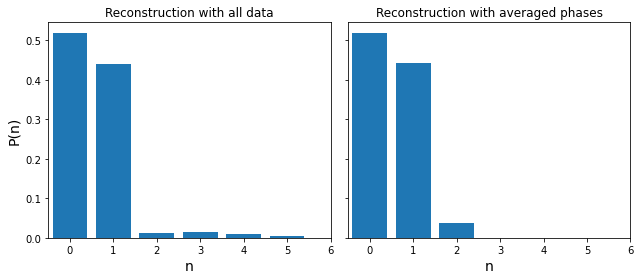

In [8]:

def Convex_optimization_state_tomography(Matrix_prob, Measurements, gamma):
    #gamma: small regularizing parameter that helps with noise. Aribitrary, but should be small, order of 0.01 or less
    C = Matrix_prob; #This is the input coefficient matrix
    Meas = Measurements; #These are the measured overlap fidelities
    P = cp.Variable((N_dim,N_dim), PSD = True) #unknown density matrix
    #P = cp.Variable((N_dim,N_dim), Hermitian = True) #set hermitian true when I include phase
   
    Error = cp.norm(C@cp.vec(P) - Meas,2) #second paramter gives norm type

    Obj_detect = cp.Minimize(Error + gamma*cp.norm(cp.vec(P),2))
    constraints = [cp.trace(P)==1]# physicality constraint
    for i in range(N_dim):
        constraints.append(cp.real(P[i][i]) >= 0) #ensure diagonals are real
        if i>5:
            #based on direct photon counting (without overlap tomo), we know the probability distribution for the state is zero beyond 4 photons
            constraints.append(cp.real(P[i][i]) == 0) 
    Prob_detect = cp.Problem(Obj_detect,constraints)
    Prob_detect.solve(verbose = False) 
    #Prob_detect.solve(cp.CVXOPT)  #can choose a different solver
    p_values = (P.value)
    return p_values

P1 = Convex_optimization_state_tomography(Final_prob, Fid_array_fin, .01) #All data points used
P2 = Convex_optimization_state_tomography(Final_prob, Fid_array_fin_averaged, .01) #averaged phases

P_arr1 = np.array(P1).reshape(N_dim,N_dim)
P_arr2 = np.array(P2).reshape(N_dim,N_dim)


#Plots show the reconstructed photon number distributions
fig, ax = plt.subplots(1,2, sharey=True,figsize=(9,4))

ax[0].bar(range(N_dim),P_arr1.diagonal(0))
ax[0].set_title('Reconstruction with all data')
ax[0].set_ylabel('P(n)',fontsize=14)
ax[0].set_xlabel('n',fontsize=14)
ax[0].set_xlim([-0.5,6])
#ax1.xlabel('n',fontsize=12)
ax[1].bar(range(N_dim),P_arr2.diagonal(0))
ax[1].set_title('Reconstruction with averaged phases')
ax[1].set_xlabel('n',fontsize=14)
ax[1].set_xlim([-0.5,6])
plt.tight_layout()
plt.show()



Looking at the photon-number distributions, we see that for the most part we just have vacuum and single photon probabilities. This makes sense, since we send a single photon through a lossy channel. Now let's plot the Wigner functions for both reconstructions. 

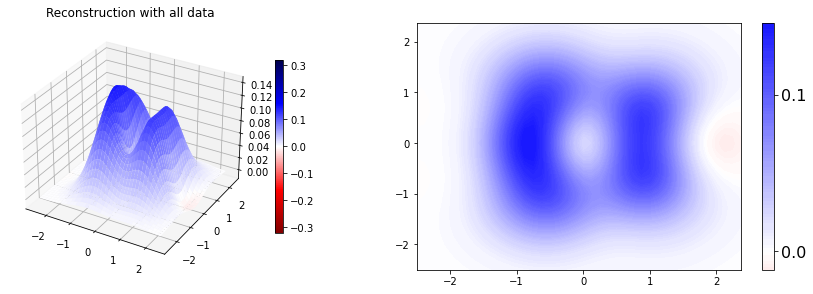

Fidelity with a single photon is  0.441096175995693


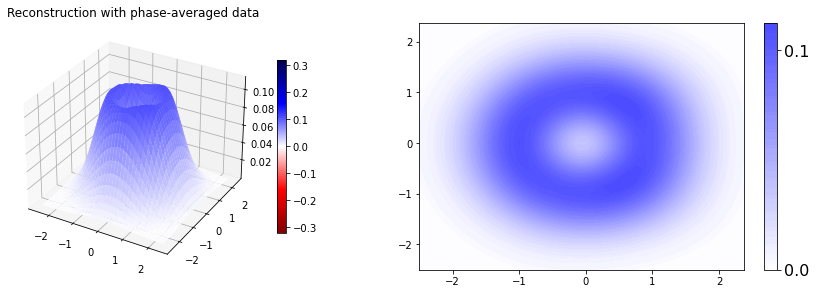

Fidelity with a single photon is  0.4430140560643


In [9]:
xvec = np.arange(-20.,20.)*5./40
yvec = np.arange(-50.,50)*5/40
X,Y = np.meshgrid(xvec, xvec) 
X1,Y1 = np.meshgrid(yvec,yvec)

q_tomo1=Qobj(P_arr1)
q_tomo2=Qobj(P_arr2)
W1=wigner(q_tomo1,xvec,xvec)
W2=wigner(q_tomo2,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W1, 80, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32)
#cb = fig.colorbar(p, shrink = 0.7)
cb = fig.colorbar(p, shrink = 1)
cb.ax.tick_params(labelsize=16)
cb.set_ticks([-0.3,-0.2,-0.1, 0,0.1,0.2,0.3]);

# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W1, rstride=1, cstride=1, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Reconstruction with all data')
plt.show()
print('Fidelity with a single photon is ',fidelity(q_tomo1,fock(N_dim,1))**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W2, 80, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32)
#cb = fig.colorbar(p, shrink = 0.7)
cb = fig.colorbar(p, shrink = 1)
cb.ax.tick_params(labelsize=16)
cb.set_ticks([-0.3,-0.2,-0.1, 0,0.1,0.2,0.3]);

# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W2, rstride=1, cstride=1, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Reconstruction with phase-averaged data')
plt.show()
print('Fidelity with a single photon is ',fidelity(q_tomo2,fock(N_dim,1))**2)


The above Wigner functions do not dip negative since the overall loss in this run of the experiment slightly exceed 50%. While the phase-averaged data more closely resembles the symmetry of the Fock state, the whole data set is not too bad. The asymmetries originate from experimental imperfections such as finite sampling and amplitude fluctuations over the course of data collection (~6 hours). 

Fortunately, loss is a statistical process that uniquely maps one density operator to another loss-degraded density operator. As discussed in the main text, another SDP optimiztion problem can be solved to determine the true density matrix before loss. First, define 'matrix_L' which is the matrix that applies loss to the density matrix. Here, loss was as high as 60%.

In [10]:
refl_tot=0.6
'''Define the Matrix to correct the loss on the reconstructed \rho' '''
#dim_in=N_dim  #Hilbert space dimension cuttoff of the input quantum state
dim_out=N_dim #Hilbert space dimentsion cuttoff of the output (measured) state
r=np.sqrt(refl_tot) #loss BS reflection coefficient
t=np.sqrt(1-refl_tot) #loss BS transmission coefficient

#Define my 'ragged' matrix that gives me the transformation between my initial state
#and my final state after the BS and trace.  Here, each layer gives a matrix that
#maps ones of the diagonals of my new, measured density matrix to the same 
#diagonal of my original matrix.

matrix_L=[]
for i in range(N_dim):
    M=[]
    for j in range(dim_out-i):
        row=[]
        for k in range(dim_out-i):
            if k < j: #ensures the result is upper triangular
                val=0
            else:
                val=(binom(k,k-j)*binom(i+k,k-j))**(1/2)*(refl_tot)**((k-j))*(1-refl_tot)**(j+(i/2))
            row.append(val) #appends each value to the k^th position in the j^th row
        M.append(row) #appends the j^th row to the i^th matrix
    matrix_L.append(M)
            
#For example, the main diagonals map according to
#rho_out.diagonal(0)=np.matmul(matrix_M[0],rho_in.diagonal(0))            

#Note, this is NOT YET NORMALIZED!  I still need to do that in the optimization algorithm

#rearrange the varibles into the same form that works with the SDP problem
rho_temp1=np.zeros((dim_out,dim_out),complex) #all data points
rho_temp2=np.zeros((dim_out,dim_out),complex) #phase-averaged data
for i in range(N_dim):
    for j in range(N_dim):      
        rho_temp1[i][j]=P_arr1[i][j]
        rho_temp2[i][j]=P_arr2[i][j]


The next cell has the SDP algorithm used to correct for loss. As a different matrix must map each diagonal (not just the main diagonal) of the density matrix into a loss-degraded density matrix, this SDP problem actually optimizes over several matrix inversions. It is thus a bit more messy than before.

In [15]:
'''Method using SDPs to reconstruct for loss, which uses the first matrix, matrix_L as the loss matrix
which we need to find the inverse of'''
from cvxopt import blas, lapack, solvers

def Convex_optimization_loss_reconstruct(Matrix_map, Rho_measured, gamma,delta):
    M = np.asarray(Matrix_map); 
    Rho = Rho_measured;
    Error1=0
    Error2=0
    P = cp.Variable((N_dim,N_dim), PSD = True) #set hermitian true when I include phase
    #P = cp.Variable((N_dim,N_dim), complex = True)
    #P = cp.Variable((N_dim,N_dim), hermitian=True)
    norm=0

    shifted=[]
    for i in range(N_dim):
        row=[]
        for j in range(N_dim-i):
            row.append(P[j][i+j])
        shifted.append(row)
    #The above loop rearranges the variable matrix P into a new matrix where
    #the new rows are now the different diagonals of the original P matrix
    Error_vec=[]    
    for k in range(N_dim):    
        vec=[]
        for i in range(N_dim-k):
            num=0
            for j in range(N_dim-k):
                num=num+M[k][i][j]*shifted[k][j]
                #inner loop performs matrix multiplication between
                #one of the rows from the new shifted P matrix and
                #one of the matrices that needs to be inverted, M[k].
            vec.append(num)
            #This inner multiplications results in the vector vec
            #I also use this number to subract element-wise the corresponding
            #values of the diagonals of the measured Rho
            temp_error=cp.abs(num-np.diagonal(Rho,k)[i])
            Error1=Error1+cp.power(temp_error,2)


            
    shifted2=[]
    for i in range(N_dim):
        row=[]
        for j in range(N_dim-i):
            row.append(P[j+i][j])
        shifted2.append(row)
        
    for k in range(N_dim):    
        vec=[]
        for i in range(N_dim-k):
            num=0
            for j in range(N_dim-k):
                num=num+M[k][i][j]*shifted2[k][j]
                #inner loop performs matrix multiplication between
                #one of the rows from the new shifted P matrix and
                #one of the matrices that needs to be inverted, M[k].
            vec.append(num)
            #This inner multiplications results in the vector vec
            #I also use this number to subract element-wise the corresponding
            #values of the diagonals of the measured Rho
            temp_error=cp.abs(num-np.diagonal(Rho,k)[i].conj())
            Error2=Error2+cp.power(temp_error,2)

    Obj_detect = cp.Minimize(Error1+Error2+ gamma*cp.norm(P,2))

    positive_diag=[]
        
    constraints = [cp.trace(P)==1,cp.diag(cp.real(P))>=0] #constrains the density matrix to be physical
    for i in range(N_dim):
        for j in range(N_dim):
            if i==j:
                constraints.append(cp.abs(P[i][j]) <= (1/np.sqrt(1-refl_tot)**(i+j))*cp.abs(Rho[i][j])+delta)
    Prob_detect = cp.Problem(Obj_detect,constraints)
    Prob_detect.solve(verbose = False) #set verbose = True to see output logs  
    #Prob_detect.solve(cp.CVXOPT,verbose = False) 

    p_values = (P.value)
    return p_values

Rho1=Convex_optimization_loss_reconstruct(matrix_L,rho_temp1,0.0,0.0) #all data
Rho2=Convex_optimization_loss_reconstruct(matrix_L,rho_temp2,0.0,0.0) #phase-averaged data

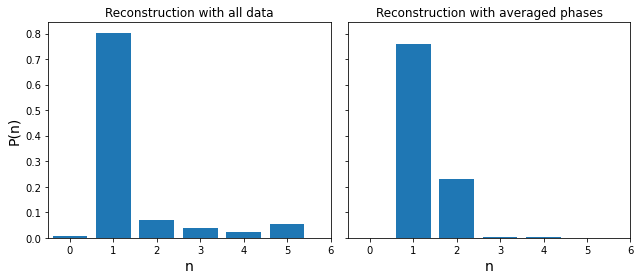

In [16]:
#Plots show the reconstructed photon number distributions
fig, ax = plt.subplots(1,2, sharey=True,figsize=(9,4))

ax[0].bar(range(N_dim),Rho1.diagonal(0))
ax[0].set_title('Reconstruction with all data')
ax[0].set_ylabel('P(n)',fontsize=14)
ax[0].set_xlabel('n',fontsize=14)
ax[0].set_xlim([-0.5,6])
#ax1.xlabel('n',fontsize=12)
ax[1].bar(range(N_dim),Rho2.diagonal(0))
ax[1].set_title('Reconstruction with averaged phases')
ax[1].set_xlabel('n',fontsize=14)
ax[1].set_xlim([-0.5,6])
plt.tight_layout()
plt.show()

From the above probability distributions, it is clear that the loss reconstruction removed the vacuum component and produced a state that is considerably closer to the pure single-photon we expect. However, the relatively large 2 photon component may not be erroneous after all. In fact, the pump power was too high, so the 2 photon probability in reality was likely non-negligible. Thus, the tomography protocol was able to provide us information on the generated state.

We can also plot the density matrix elements, followed by Wigner functions of the full reconstruction with loss compensation.

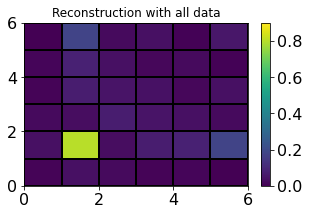

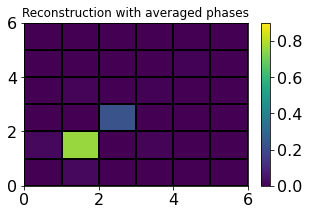

In [17]:
s1=np.abs(Rho1)
temp1=np.delete(s1,np.s_[6:],0)
state1=np.delete(temp1,np.s_[6:],1)

s2=np.real(Rho2)
temp2=np.delete(s2,np.s_[6:],0)
state2=np.delete(temp2,np.s_[6:],1)

fig = plt.figure(figsize=(5,3))
plt.pcolormesh(state1, vmin=0.0, vmax=.9,edgecolor='k', linewidth=1)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([0,2,4,6])
plt.tick_params(labelsize=16)
plt.title('Reconstruction with all data')
plt.show()

#plt.imshow(state)
fig = plt.figure(figsize=(5,3))
plt.pcolormesh(state2, vmin=0.0, vmax=.9,edgecolor='k', linewidth=1)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=16)
plt.xticks([0,2,4,6])
plt.tick_params(labelsize=16)
plt.title('Reconstruction with averaged phases')
plt.show()

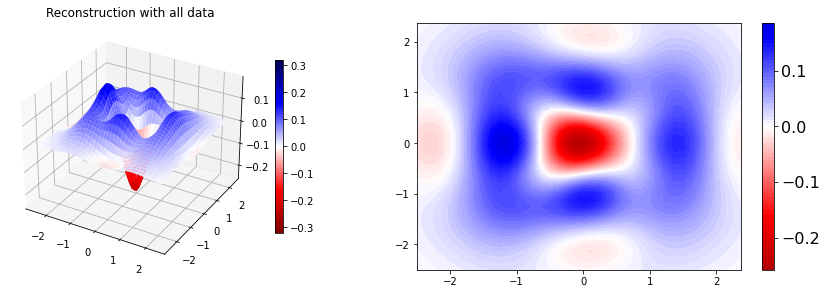

Fidelity with a single photon is  0.8034190879882358


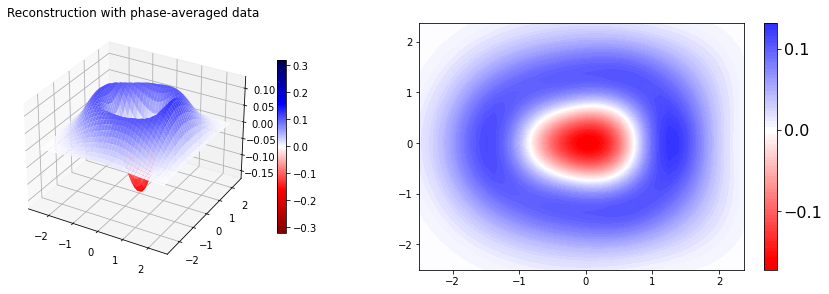

Fidelity with a single photon is  0.7594397813576096


In [18]:
xvec = np.arange(-20.,20.)*5./40
yvec = np.arange(-50.,50)*5/40
X,Y = np.meshgrid(xvec, xvec) 
X1,Y1 = np.meshgrid(yvec,yvec)

q_tomo1=Qobj(Rho1)
q_tomo2=Qobj(Rho2)
W1=wigner(q_tomo1,xvec,xvec)
W2=wigner(q_tomo2,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W1, 80, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32)
#cb = fig.colorbar(p, shrink = 0.7)
cb = fig.colorbar(p, shrink = 1)
cb.ax.tick_params(labelsize=16)
cb.set_ticks([-0.3,-0.2,-0.1, 0,0.1,0.2,0.3]);

# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W1, rstride=1, cstride=1, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Reconstruction with all data')
plt.show()
print('Fidelity with a single photon is ',fidelity(Qobj(Rho1),fock(N_dim,1))**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W2, 80, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32)
#cb = fig.colorbar(p, shrink = 0.7)
cb = fig.colorbar(p, shrink = 1)
cb.ax.tick_params(labelsize=16)
cb.set_ticks([-0.3,-0.2,-0.1, 0,0.1,0.2,0.3]);

# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W2, rstride=1, cstride=1, cmap=cm.seismic_r,vmin=-0.32,vmax=0.32, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Reconstruction with phase-averaged data')
plt.show()
print('Fidelity with a single photon is ',fidelity(Qobj(Rho2),fock(N_dim,1))**2)
